## Importation des librairies et du dataset

In [20]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
# import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
fichier_inverse = pd.read_csv("../csv_docs/fichier_inverse.csv")
fichier_inverse = fichier_inverse.drop("Unnamed: 0", axis=1)
fichier_inverse

,Word,Document,Frequence,Poid
0,0,D443,1,0.210977
1,0.18,D1090,1,0.527442
2,0.5,D720,1,0.791163
3,0.7%,D691,1,0.395581
4,000,D687,2,1.071347
...,...,...,...,...
77177,zipfian,D329,1,0.527442
77178,zone,D62,2,0.575391
77179,zoolog,D755,1,0.632930
77180,zuckerman,D1291,1,1.431959


In [3]:
info_queries = pd.read_csv("../csv_docs/info_queries.csv")
info_queries = info_queries.drop("Unnamed: 0", axis=1)
info_queries

,Query,Word
0,Q1,problem
1,Q1,concern
2,Q1,make
3,Q1,descript
4,Q1,titl
...,...,...
5188,Q112,algorithm
5189,Q112,compar
5190,Q112,previous
5191,Q112,describ


### SRI basé sur le modèle probabiliste avec la fonction BM25

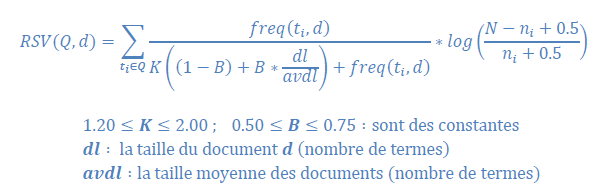

In [9]:
# SRI Probabiliste en utilisant la fonction BM25
def bm25(query, fichier_inverse, info_queries, B= 0.6, K= 1.5):
    N = len(fichier_inverse['Document'].unique()) # Nombre de documents

    words = list(info_queries.loc[info_queries["Query"] == query, "Word"]) # Liste des mots de la requête
    df = fichier_inverse.loc[fichier_inverse["Word"].isin(words)] # Fichier inverse contenant les mots de la requête

    nb_doc = df.groupby('Word')['Document'].count().to_frame() # Nombre de documents contenant les mots de la requête
    nb_doc.reset_index(inplace=True) # Réinitialisation de l'index
    nb_doc.rename(columns = {'Document':'Nombre document contenu'}, inplace = True) # Renommage de la colonne
    df = df.merge(nb_doc, on="Word") # Fusion des deux dataframes

    nb_termes_doc = fichier_inverse.groupby('Document')['Frequence'].sum().to_frame() # Nombre de termes par document
    nb_termes_doc.reset_index(inplace=True) # Réinitialisation de l'index
    nb_termes_doc.rename(columns = {'Frequence':'dl'}, inplace = True) # Renommage de la colonne
    df = df.merge(nb_termes_doc, on="Document") # Fusion des deux dataframes
    
    df["avdl"]= nb_termes_doc["dl"].mean() # Moyenne du nombre de termes par document
    
    rsv_list = [] # Liste des RSV

    for d in df["Document"].unique(): # Pour chaque document
        temp = df.loc[df["Document"] == d, ["Frequence", "Nombre document contenu", "dl", "avdl"]] # Dataframe temporaire
        ni = temp["Nombre document contenu"] # Nombre de documents contenant le mot

        # Il est 3h du mat flemme d'expliquer la formule regarde le pdf tu vas comprendre
        rsv = np.multiply(np.divide(temp["Frequence"],
                            np.add(np.multiply(K, 
                            np.add(np.subtract(1, B), 
                                    np.multiply(B, np.divide(temp["dl"], temp["avdl"])))), 
                                                temp["Frequence"])), 
                                                np.log10(np.divide(np.add(
                                                        np.subtract(N, ni), 0.5), np.add(ni, 0.5))))
        
        rsv_list.append([d, np.sum(rsv)]) # Ajout du RSV dans la liste

    df = pd.DataFrame(rsv_list, columns = ["Document","RSV"]) # Création d'un dataframe avec la liste des RSV
    df = df.sort_values(by=["RSV"]) # Tri des RSV par ordre croissant

    return df.reindex(index=df.index[::-1]) # Retourne le dataframe trié par ordre décroissant

bm25("Q1", fichier_inverse, info_queries, 0.6, 1.5)

,Document,RSV
77,D429,2.420663
163,D42,2.395005
54,D447,2.377216
257,D1419,2.347758
212,D489,2.318881
...,...,...
763,D593,0.182191
586,D400,0.180956
814,D158,0.180015
808,D248,0.180015


## Evaluation de SRI probabiliste

### importation des documents pertinents donnée par l'environement de teste

In [6]:
def load_rel():
    path ='../cisi/CISI.REL'
    with open(path) as f:
        rel_set = {}
        for l in f.readlines():
            qry_id = int(l.lstrip(" ").strip(
                "\n").split("\t")[0].split(" ")[0])
            doc_id = int(l.lstrip(" ").strip(
                "\n").split("\t")[0].split(" ")[-1])
            qry_id= f"Q{qry_id}"
            doc_id= f"D{doc_id}"
            if qry_id in rel_set:
                rel_set[qry_id].append(doc_id)
            else:
                rel_set[qry_id] = []
                rel_set[qry_id].append(doc_id)
    return rel_set
rel = load_rel()

In [14]:
# cette fonction retourne les measures de performance
def evaluation(function,fichier_inverse,info_queries,rel,sueil=None):
    data=[] # contiendra les mesures de performance avec tout les requetes
    for qr in rel.keys():
        if sueil is None:
            # selectioner les n premier elements tel que n = nombre des document relative au requete 
            docPert = function(qr, fichier_inverse, info_queries).head(len(rel[qr])) 
        else:
            docPert = function(qr, fichier_inverse, info_queries)          
            docPert = docPert[docPert["RSV"]>sueil] # filtrer avec similarité supèrieur au suiel
        if len(docPert["Document"])>0:
            # summary contient les mesures d'une requete
            summary=[qr]
            precision = sum([doc in rel[qr] for doc in docPert["Document"]])/len(docPert["Document"]) 
            summary.append(precision)
            Pat5 = sum([doc in rel[qr] for doc in docPert["Document"]][0:5])/5
            summary.append(Pat5)
            Pat10 = sum([doc in rel[qr] for doc in docPert["Document"]][0:10])/10
            summary.append(Pat10)
            rappel= sum([doc in rel[qr] for doc in docPert["Document"]])/len(rel[qr]) 
            summary.append(rappel) 
            if precision*rappel !=0:
                Fmesure= (2*precision*rappel)/(precision+rappel)
            else: 
                Fmesure=0
            summary.append(Fmesure)
            data.append(summary)
    return pd.DataFrame(data, columns = ["Query","Precision","𝑃@5","𝑃@10","Rappel","F-mesure"])

In [15]:
seuil =0.3
data=[]
while seuil<2.4:
    summary=[seuil]
    bm25_evaluation= evaluation(bm25,fichier_inverse,info_queries,rel,seuil)
    summary.extend(list(bm25_evaluation.drop("Query",axis=1).mean())) # ajouter les moyenne des measures avec les suiel corrant
    data.append(summary)
    seuil+=0.5
bm25_evaluation_resume = pd.DataFrame(data, columns = ["seuil","moyPrecision","moy𝑃@5","moy𝑃@10","moyRappel","moyF-mesure"])
bm25_evaluation_resume

,seuil,moyPrecision,moy𝑃@5,moy𝑃@10,moyRappel,moyF-mesure
0,0.3,0.052386,0.336842,0.301316,0.865085,0.089741
1,0.8,0.091117,0.336842,0.301316,0.649684,0.118796
2,1.3,0.163686,0.334211,0.273684,0.484148,0.113320
3,1.8,0.183816,0.303030,0.243939,0.412479,0.112729
4,2.3,0.246006,0.301887,0.243396,0.382115,0.119726


meilleur suiel avec la methode "jaccard" c'est : 2.3 (en se basant sur le f-measure)

In [16]:
bm25_evaluation= evaluation(bm25,fichier_inverse,info_queries,rel,2.3)
bm25_evaluation

,Query,Precision,𝑃@5,𝑃@10,Rappel,F-mesure
0,Q1,0.500000,0.4,0.3,0.065217,0.115385
1,Q2,1.000000,0.2,0.1,0.038462,0.074074
2,Q3,1.000000,0.2,0.1,0.022727,0.044444
3,Q4,1.000000,0.2,0.1,0.125000,0.222222
4,Q7,0.000000,0.0,0.0,0.000000,0.000000
5,Q9,0.500000,0.2,0.1,0.029412,0.055556
6,Q10,1.000000,0.2,0.1,0.038462,0.074074
7,Q15,0.500000,0.2,0.1,0.012195,0.023810
8,Q17,1.000000,0.2,0.1,0.038462,0.074074
9,Q18,0.187500,0.2,0.2,0.272727,0.222222


#### Trace de courbe Rappel-precision

In [26]:
def get_RapPrec_Points(function,fichier_inverse, info_queries,rel):
    q = "Q3" # prendre la requete Q3 comme donnée de teste
    nb_doc_pertinent= 10  # le nombre de document pertinents dans rel on prend 10 mais en vrai ce sont 44
    # prendre les 10 premier elements dans l'ordre de similarité comme document sélectionées
    result = function(q, fichier_inverse, info_queries).head(nb_doc_pertinent)
    result['pertinent'] = result['Document'].apply(lambda x: True if x in rel[q] else False)
    RP= []
    for i in range(len(result['pertinent'])):
        row=[]
        if result['pertinent'].iloc[i]== True:
            rappel= (i+1)/nb_doc_pertinent    # formule de rappel
            row.append(rappel)
            pecision = (len(RP)+1)/(i+1)    # formule de precision
            row.append(pecision)
            RP.append(row)
    print(result)
    return pd.DataFrame(RP, columns = ["Rappel","Precision"])

In [27]:
RP = get_RapPrec_Points(bm25,fichier_inverse, info_queries,rel)

    Document       RSV  pertinent
43     D1181  2.401995       True
22      D540  1.739316       True
13      D469  1.608669       True
44     D1179  1.418520       True
48     D1133  1.271169      False
28     D1077  1.235996      False
101    D1277  1.220042      False
85      D160  1.200920      False
66     D1235  1.193454      False
105    D1249  1.164580      False


   Rappel  Precision
0     0.1        1.0
1     0.2        1.0
2     0.3        1.0
3     0.4        1.0
0     1.0        0.0


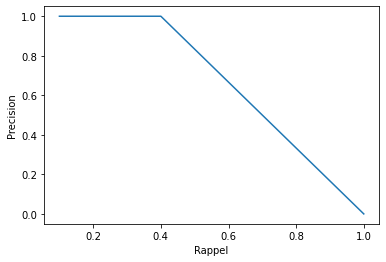

In [30]:
# Courbe rappel/précision pour une requête à chaque document pertinent
df2 = pd.DataFrame({"Rappel":[1],
                    "Precision":[0]}) #la derniere etape le rappel tend vers 1 et la precision vers 0
RP = RP.append(df2)
print(RP)
plt.plot(RP["Rappel"], RP["Precision"])
plt.xlabel('Rappel')
plt.ylabel('Precision')
plt.show()